### __Importing the dependencies__

In [78]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from utils import embedded_method
import warnings

warnings.filterwarnings("ignore")

### __Loading dataset__

In [79]:
data = load_breast_cancer()
data = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [80]:
data.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [81]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['target'], axis=1), 
                                                    data.target, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((455, 30), (114, 30))

### __Lasso__

<div align="justify">

Regularization with Lasso.Lasso (L1) has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model

</div>

In [82]:
scaler = RobustScaler()
scaler.fit(X_train)

,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False


In [83]:
sel_ = SelectFromModel(
    LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=0)
)
sel_.fit(scaler.transform(X_train), y_train)

,estimator,LogisticRegre...r='liblinear')
,threshold,None
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True


In [84]:
selected_feat = X_train.columns[(sel_.get_support())]

In [85]:
print('Total features: {}'.format((X_train.shape[1])))

Total features: 30


In [86]:
print('Selected features: {}'.format(len(selected_feat)))

Selected features: 14


In [87]:
print('Features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

Features with coefficients shrank to zero: 16


In [88]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]

In [89]:
removed_feats

Index(['mean radius', 'mean perimeter', 'mean area', 'mean smoothness',
       'mean compactness', 'mean concavity', 'mean fractal dimension',
       'texture error', 'perimeter error', 'smoothness error',
       'concavity error', 'concave points error', 'symmetry error',
       'worst radius', 'worst perimeter', 'worst compactness'],
      dtype='object')

In [90]:
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))

In [91]:
X_train_selected.shape, X_test_selected.shape

((455, 14), (114, 14))

### __Random Forest Importance__

Feature ranking:
1. feature no:27 feature name:worst concave points (0.206316)
2. feature no:22 feature name:worst perimeter (0.147163)
3. feature no:7 feature name:mean concave points (0.100672)
4. feature no:20 feature name:worst radius (0.082449)
5. feature no:6 feature name:mean concavity (0.060420)
6. feature no:2 feature name:mean perimeter (0.048284)
7. feature no:23 feature name:worst area (0.046151)
8. feature no:3 feature name:mean area (0.038594)
9. feature no:13 feature name:area error (0.035627)
10. feature no:0 feature name:mean radius (0.030476)
11. feature no:10 feature name:radius error (0.028711)
12. feature no:26 feature name:worst concavity (0.028533)
13. feature no:12 feature name:perimeter error (0.019986)
14. feature no:21 feature name:worst texture (0.018623)
15. feature no:1 feature name:mean texture (0.013840)
16. feature no:25 feature name:worst compactness (0.013195)
17. feature no:29 feature name:worst fractal dimension (0.011840)
18. feature no:24 feature 

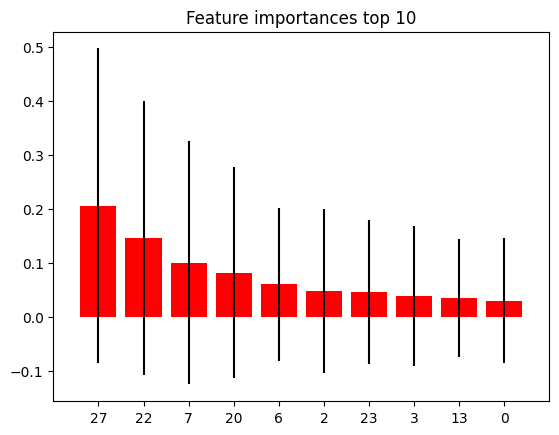

In [92]:
model = embedded_method.rf_importance(X_train=X_train,y_train=y_train,
                             max_depth=10,top_n=10)

In [93]:
feature_selection = SelectFromModel(model, threshold=0.05,prefit=True) 
selected_feat = X_train.columns[(feature_selection.get_support())]

In [94]:
selected_feat

Index(['mean concavity', 'mean concave points', 'worst radius',
       'worst perimeter', 'worst concave points'],
      dtype='object')

In [95]:
feature_selection2 = SelectFromModel(model, threshold='2*median',prefit=True) 
selected_feat2 = X_train.columns[(feature_selection2.get_support())]

In [96]:
selected_feat2

Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'radius error', 'area error', 'worst radius',
       'worst perimeter', 'worst area', 'worst concavity',
       'worst concave points'],
      dtype='object')

### __Gradient Boosted Trees Importance__

Feature ranking:
1. feature no:27 feature name:worst concave points (0.694265)
2. feature no:23 feature name:worst area (0.131676)
3. feature no:4 feature name:mean smoothness (0.033800)
4. feature no:8 feature name:mean symmetry (0.018607)
5. feature no:22 feature name:worst perimeter (0.016628)
6. feature no:21 feature name:worst texture (0.013814)
7. feature no:2 feature name:mean perimeter (0.013031)
8. feature no:26 feature name:worst concavity (0.010121)
9. feature no:13 feature name:area error (0.009215)
10. feature no:17 feature name:concave points error (0.008310)
11. feature no:10 feature name:radius error (0.005939)
12. feature no:0 feature name:mean radius (0.005684)
13. feature no:18 feature name:symmetry error (0.005479)
14. feature no:12 feature name:perimeter error (0.005403)
15. feature no:3 feature name:mean area (0.005056)
16. feature no:16 feature name:concavity error (0.003559)
17. feature no:6 feature name:mean concavity (0.003366)
18. feature no:19 feature name:f

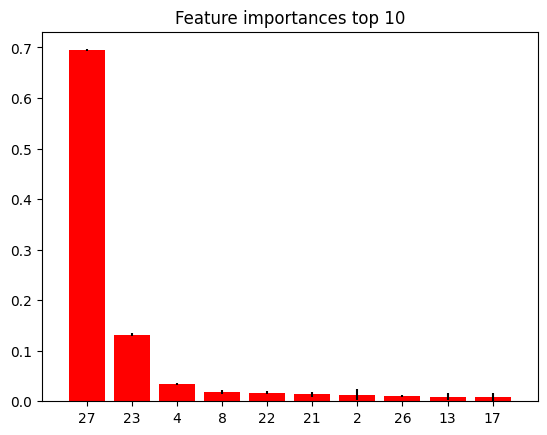

In [97]:
model = embedded_method.gbt_importance(X_train=X_train,y_train=y_train,
                             max_depth=10,top_n=10)

In [98]:
feature_selection = SelectFromModel(model, threshold=0.01,prefit=True) 
selected_feat = X_train.columns[(feature_selection.get_support())]

In [99]:
selected_feat

Index(['mean perimeter', 'mean smoothness', 'mean symmetry', 'worst texture',
       'worst perimeter', 'worst area', 'worst concavity',
       'worst concave points'],
      dtype='object')